In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from cinnamon.drift import OutputDriftDetector

# Iris Data

In [2]:
dataset = datasets.load_iris()

In [3]:
X = pd.DataFrame(dataset.data, columns = dataset.feature_names)
y = dataset.target

In [4]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# This is multiclass classification pbm with 3 classes
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([50, 50, 50]))

# Build XGBoost model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [7]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    learning_rate=0.05,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=2021)

In [8]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=10)

[17:32:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.03790
[10]	validation_0-mlogloss:0.62400
[20]	validation_0-mlogloss:0.41802
[30]	validation_0-mlogloss:0.30619
[40]	validation_0-mlogloss:0.24457
[50]	validation_0-mlogloss:0.21297
[60]	validation_0-mlogloss:0.19405
[70]	validation_0-mlogloss:0.18142
[80]	validation_0-mlogloss:0.17251
[90]	validation_0-mlogloss:0.16548
[100]	validation_0-mlogloss:0.16379
[110]	validation_0-mlogloss:0.16987
[116]	validation_0-mlogloss:0.17263


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=2021, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2021, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Analyze data drift with ModelDriftExplainer

The experiment is done with a random split so we should not detect a data drift

### prediction_type == "proba"

In [9]:
output_drift_detector = OutputDriftDetector(task='classification', prediction_type='proba')

In [10]:
output_drift_detector.fit(clf.predict_proba(X_train), clf.predict_proba(X_test), y1=y_train, y2=y_test)

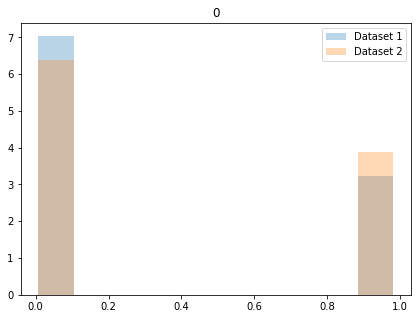

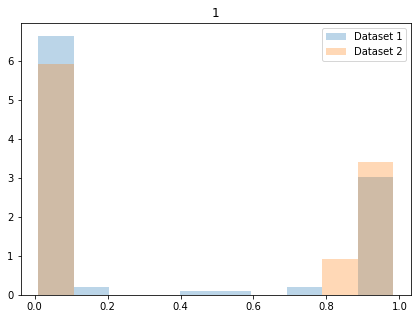

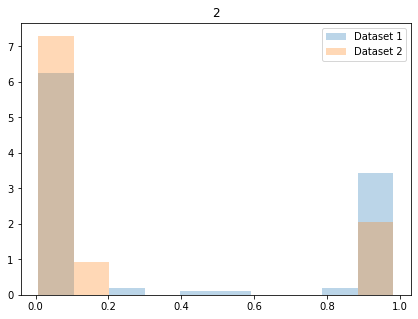

[DriftMetricsNum(mean_difference=0.06122570359665486, wasserstein=0.06138405880136859, ks_test=BaseStatisticalTestResult(statistic=0.1111111111111111, pvalue=0.7937999899885733)),
 DriftMetricsNum(mean_difference=0.08154049228640303, wasserstein=0.08205600790975118, ks_test=BaseStatisticalTestResult(statistic=0.12698412698412698, pvalue=0.6467769104301898)),
 DriftMetricsNum(mean_difference=-0.1427661934187488, wasserstein=0.14276781702443725, ks_test=BaseStatisticalTestResult(statistic=0.19047619047619047, pvalue=0.18058500659491114))]

In [11]:
# no apparent drift in distributions of log-softmax predictions
output_drift_detector.plot_prediction_drift()
output_drift_detector.get_prediction_drift()

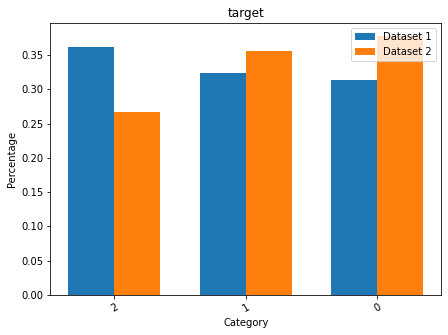

DriftMetricsCat(wasserstein=0.09523809523809523, jensen_shannon=0.07382902143706498, chi2_test=Chi2TestResult(statistic=1.3333333333333333, pvalue=0.5134171190325922, dof=2, contingency_table=       0     1     2
X1  33.0  34.0  38.0
X2  17.0  16.0  12.0))

In [12]:
output_drift_detector.plot_target_drift()
output_drift_detector.get_target_drift()

In [13]:
output_drift_detector.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=1.0, log_loss=0.045063073312242824), dataset2=ClassificationMetrics(accuracy=0.9333333333333333, log_loss=0.16192325585418277))

In [14]:
output_drift_detector.class_names

['0', '1', '2']

### prediction_type == "label"

In [15]:
output_drift_detector2 = OutputDriftDetector(task='classification', prediction_type='label')

In [16]:
output_drift_detector2.fit(clf.predict(X_train), clf.predict(X_test),
                            y_train, y_test)

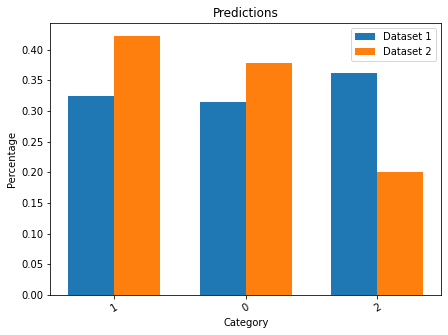

[DriftMetricsCat(wasserstein=0.16190476190476188, jensen_shannon=0.12861925049715453, chi2_test=Chi2TestResult(statistic=3.879642904933953, pvalue=0.14372961005414284, dof=2, contingency_table=       0     1     2
 X1  33.0  34.0  38.0
 X2  17.0  19.0   9.0))]

In [17]:
output_drift_detector2.plot_prediction_drift()
output_drift_detector2.get_prediction_drift()

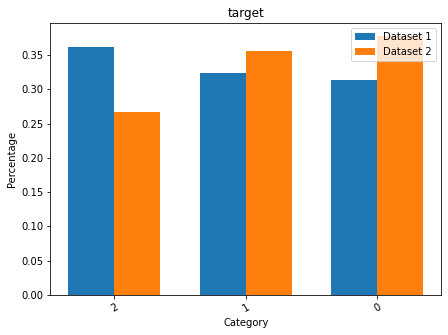

DriftMetricsCat(wasserstein=0.09523809523809523, jensen_shannon=0.07382902143706498, chi2_test=Chi2TestResult(statistic=1.3333333333333333, pvalue=0.5134171190325922, dof=2, contingency_table=       0     1     2
X1  33.0  34.0  38.0
X2  17.0  16.0  12.0))

In [18]:
output_drift_detector2.plot_target_drift()
output_drift_detector2.get_target_drift()

In [19]:
output_drift_detector2.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=1.0, log_loss=None), dataset2=ClassificationMetrics(accuracy=0.9333333333333333, log_loss=None))

### prediction_type == "raw"

In [20]:
output_drift_detector3 = OutputDriftDetector(task='classification', prediction_type='raw')

In [21]:
output_drift_detector3.fit(clf.predict(X_train, output_margin=True), clf.predict(X_test, output_margin=True),
                           y1=y_train, y2=y_test)

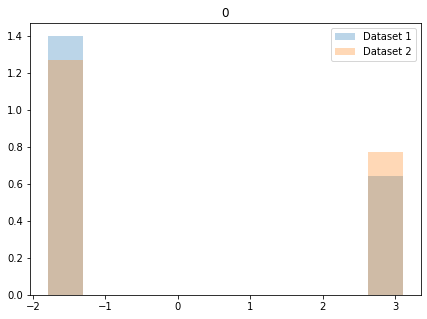

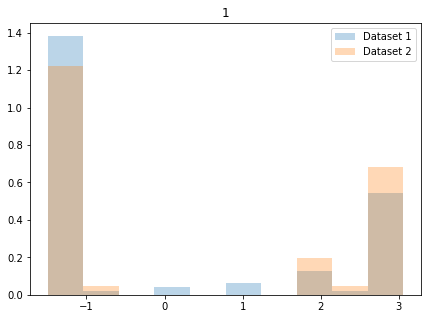

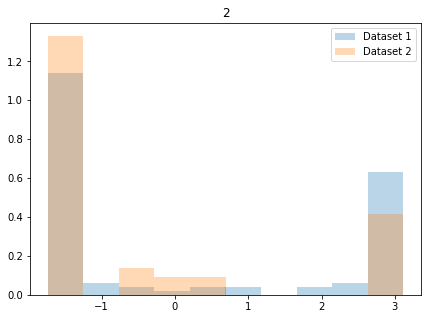

[DriftMetricsNum(mean_difference=0.31093458145383807, wasserstein=0.310934581453838, ks_test=BaseStatisticalTestResult(statistic=0.06349206349206349, pvalue=0.9987212484986795)),
 DriftMetricsNum(mean_difference=0.3232848411632908, wasserstein=0.3318073130907522, ks_test=BaseStatisticalTestResult(statistic=0.12698412698412698, pvalue=0.6467769104301898)),
 DriftMetricsNum(mean_difference=-0.5564053781212321, wasserstein=0.5568392310587188, ks_test=BaseStatisticalTestResult(statistic=0.17142857142857143, pvalue=0.2821678346768165))]

In [22]:
# no apparent drift in distributions of log-softmax predictions
output_drift_detector3.plot_prediction_drift()
output_drift_detector3.get_prediction_drift()

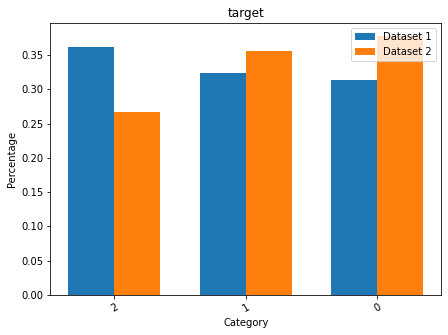

DriftMetricsCat(wasserstein=0.09523809523809523, jensen_shannon=0.07382902143706498, chi2_test=Chi2TestResult(statistic=1.3333333333333333, pvalue=0.5134171190325922, dof=2, contingency_table=       0     1     2
X1  33.0  34.0  38.0
X2  17.0  16.0  12.0))

In [23]:
output_drift_detector3.plot_target_drift()
output_drift_detector3.get_target_drift()

In [24]:
output_drift_detector3.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=1.0, log_loss=0.04506306932086036), dataset2=ClassificationMetrics(accuracy=0.9333333333333333, log_loss=0.1619232536604007))